### Firms HHI in Smartphone industry

### Data collection & Data wrangling

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#setting directory
#os.chdir("C:/Users/Lfran/OneDrive/Master thesis/Pricing power/Measurement")
share_us = pd.read_csv('vendor-US-monthly-201401-202312.csv', encoding='latin1')
share_cn = pd.read_csv('vendor-CN-monthly-201401-202312.csv', encoding='latin1')
share_in = pd.read_csv('vendor-IN-monthly-201401-202312.csv', encoding='latin1')
share_ww = pd.read_csv('vendor-ww-monthly-201401-202312.csv', encoding='latin1')
share_an = pd.read_csv('vendor-an-monthly-201401-202412.csv', encoding='latin1')
share_af = pd.read_csv('vendor-af-monthly-201401-202412.csv', encoding='latin1')
share_eu = pd.read_csv('vendor-eu-monthly-201401-202412.csv', encoding='latin1')
share_oc = pd.read_csv('vendor-oc-monthly-201401-202412.csv', encoding='latin1')
share_na = pd.read_csv('vendor-na-monthly-201401-202412.csv', encoding='latin1')
share_sa = pd.read_csv('vendor-sa-monthly-201401-202412.csv', encoding='latin1')
share_as = pd.read_csv('vendor-as-monthly-201401-202412.csv', encoding='latin1')


share_an.columns.tolist()


['Date',
 'Apple',
 'Samsung',
 'Xiaomi',
 'Huawei',
 'Unknown',
 'Sony',
 'HTC',
 'LG',
 'OnePlus',
 'Lenovo',
 'Oppo',
 'Vivo',
 'Google',
 'Motorola',
 'Archos',
 'ZTE',
 'Nokia',
 'Asus',
 'Alcatel',
 'Realme',
 'Honor',
 'Acer',
 'Cubot',
 'Meizu',
 'Infinix',
 'Itel',
 'bq',
 'Vodafone',
 'Karbonn',
 'Tecno',
 'Yu',
 'Blu',
 'Other']

In [22]:

#converting format for data to year
# Correct assignment for each frame
import pandas as pd

# List of (DataFrame, Region Label) pairs
region_data = [
    (share_us, 'US'),
    (share_cn, 'China'),
    (share_in, 'India'),
    (share_ww, 'Worldwide'),
    (share_as, 'Asia'),
    (share_eu, 'Europe'),
    (share_af, 'Africa'),
    (share_na, 'North America'),
    (share_sa, 'South America'),
]

# Process each region
processed_regions = []

for df, region in region_data:
    # Ensure 'Date' is named correctly
    df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

    # Convert Date to datetime and extract year
    df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y-%m', errors='coerce')
    df['Year'] = df['Date'].dt.year

    # Group by Year and average monthly shares
    df_yearly = df.drop(columns='Date').groupby('Year', as_index=False).mean()

    # Melt to long format
    df_long = df_yearly.melt(
        id_vars='Year',
        var_name='Company Name',
        value_name=f'Market Share {region}'
    )

    processed_regions.append(df_long)

# Optionally: merge all into one big table on ['Year', 'Company Name']
from functools import reduce
market_share_all = reduce(
    lambda left, right: pd.merge(left, right, on=['Year', 'Company Name'], how='outer'),
    processed_regions
)

# Done: `market_share_all` has average yearly market share for all regions
market_share_all.head()



,Year,Company Name,Market Share US,Market Share China,Market Share India,Market Share Worldwide,Market Share Asia,Market Share Europe,Market Share Africa,Market Share North America,Market Share South America
0,2014,360,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,AIS,NaN,NaN,NaN,0.0000,0.000000,NaN,NaN,NaN,NaN
2,2014,AT&T,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
3,2014,Acer,NaN,NaN,NaN,0.0850,0.054167,0.239167,0.039167,0.042500,0.028333
4,2014,Alcatel,0.460833,0.22,0.328333,0.5025,0.267500,0.553333,0.828333,0.849167,0.623333


### Calculating HHI per region and year

In [23]:
import pandas as pd
from functools import reduce

# 1️⃣ Identify region columns dynamically
region_columns = [col for col in market_share_all.columns if col.startswith('Market Share')]

# 2️⃣ Initialize dictionary to store HHI by region
hhi_by_region = {}

for region_col in region_columns:
    region = region_col.split()[-1]  # e.g. "US", "CN"
    
    # Drop rows where the region's market share is missing or invalid
    df_region = market_share_all.dropna(subset=['Year', region_col]).copy()
    df_region = df_region[df_region[region_col].notna() & (df_region[region_col] >= 0)]

    # Compute HHI = Σ (share²)
    hhi = (
        df_region
        .groupby('Year')[region_col]
        .apply(lambda x: (x ** 2).sum())
        .reset_index()
        .rename(columns={region_col: f'HHI {region}'})
    )

    hhi_by_region[region] = hhi

# 3️⃣ Merge all HHI tables together
hhi_all = reduce(lambda left, right: pd.merge(left, right, on='Year', how='outer'),
                 hhi_by_region.values()).sort_values('Year').reset_index(drop=True)

# 4️⃣ Optional: Scale HHI (0–10,000) if your market shares are in proportions (0–1)
if hhi_all.iloc[:, 1:].max().max() <= 1:
    hhi_all.iloc[:, 1:] = hhi_all.iloc[:, 1:] * 10_000

print("✅ Cleaned and merged HHI table:")
display(hhi_all.head())


✅ Cleaned and merged HHI table:


,Year,HHI US,HHI China,HHI India,HHI Worldwide,HHI Asia,HHI Europe,HHI Africa,HHI America
0,2014,3428.077370,1456.549042,2413.892792,1932.607548,2010.891799,2388.405499,2088.826903,2107.717779
1,2015,3363.484723,1353.921085,1876.545974,1721.022413,1699.035642,2119.853848,2002.555172,1900.859551
2,2016,3614.940963,1444.770395,1690.272047,1728.244368,1677.972778,2144.307907,2264.252159,2004.766710
3,2017,3685.550994,1379.739306,1121.783083,1621.827501,1469.067359,2205.892159,1564.763535,2397.266169
4,2018,3699.374272,1423.895593,1178.415462,1549.312431,1362.241590,2137.609417,1492.502363,2497.837162


### Calculating Firm's HHi per firm and year

In [24]:
import pandas as pd
from functools import reduce

# 1️⃣ Identify region columns dynamically
region_columns = [col for col in market_share_all.columns if col.startswith('Market Share')]

# 2️⃣ Initialize dictionary to store HHI by region
hhi_by_region = {}

for region_col in region_columns:
    region = region_col.split()[-1]  # e.g. "US", "CN"
    
    # Drop rows where the region's market share is missing or invalid
    df_region = market_share_all.dropna(subset=['Year', region_col]).copy()
    df_region = df_region[df_region[region_col].notna() & (df_region[region_col] >= 0)]

    # Compute HHI = Σ (share²)
    hhi = (
        df_region
        .groupby('Year')[region_col]
        .apply(lambda x: (x ** 2).sum())
        .reset_index()
        .rename(columns={region_col: f'HHI {region}'})
    )

    hhi_by_region[region] = hhi

# 3️⃣ Merge all HHI tables together
hhi_all = reduce(lambda left, right: pd.merge(left, right, on='Year', how='outer'),
                 hhi_by_region.values()).sort_values('Year').reset_index(drop=True)

# 4️⃣ Optional: Scale HHI (0–10,000) if your market shares are in proportions (0–1)
if hhi_all.iloc[:, 1:].max().max() <= 1:
    hhi_all.iloc[:, 1:] = hhi_all.iloc[:, 1:] * 10_000

print("✅ Cleaned and merged HHI table:")
display(hhi_all)


✅ Cleaned and merged HHI table:


,Year,HHI US,HHI China,HHI India,HHI Worldwide,HHI Asia,HHI Europe,HHI Africa,HHI America
0,2014,3428.077370,1456.549042,2413.892792,1932.607548,2010.891799,2388.405499,2088.826903,2107.717779
1,2015,3363.484723,1353.921085,1876.545974,1721.022413,1699.035642,2119.853848,2002.555172,1900.859551
2,2016,3614.940963,1444.770395,1690.272047,1728.244368,1677.972778,2144.307907,2264.252159,2004.766710
3,2017,3685.550994,1379.739306,1121.783083,1621.827501,1469.067359,2205.892159,1564.763535,2397.266169
4,2018,3699.374272,1423.895593,1178.415462,1549.312431,1362.241590,2137.609417,1492.502363,2497.837162
5,2019,3770.626702,1364.297402,1342.802761,1723.881441,1480.523268,2261.667553,1668.790263,2717.248514
6,2020,4196.530239,1640.479337,1462.759575,1858.702981,1522.507019,2321.701369,1747.011124,2712.722447
7,2021,4128.727434,2195.304306,1561.391513,1779.146754,1396.449482,2376.009281,1655.367149,2630.389235
8,2022,4092.984210,1898.742094,1544.636431,1830.602328,1446.642871,2386.644047,1650.426833,2534.200948
9,2023,4123.768990,1852.896461,1406.151209,1746.050975,1340.006690,2422.347655,1575.345382,2325.642692


In [25]:
import pandas as pd

# 1️⃣ Identify region columns dynamically
region_columns = [col for col in market_share_all.columns if col.startswith('Market Share')]

# 2️⃣ Initialize dict to store HHI contributions per region
hhi_firm_by_region = {}

for region_col in region_columns:
    region = region_col.split()[-1]  # Extract e.g. "US", "CN"
    
    # Drop missing or invalid data
    df_region = market_share_all.dropna(subset=['Year', 'Company Name', region_col]).copy()
    df_region = df_region[df_region[region_col] >= 0]
    
    # Compute each firm's squared market share
    df_region[f'HHI_contrib_{region}'] = df_region[region_col] ** 2
    
    # Keep only relevant columns
    df_region = df_region[['Year', 'Company Name', region_col, f'HHI_contrib_{region}']]
    
    # Optionally scale (if shares are proportions)
    if df_region[region_col].max() <= 1:
        df_region[region_col] *= 100  # convert to percentage
        df_region[f'HHI_contrib_{region}'] *= 10_000
    
    hhi_firm_by_region[region] = df_region

# 3️⃣ Example: view one region’s per-firm-per-year HHI contributions
display(hhi_firm_by_region['US'])


# 4️⃣ Optional: total HHI per year check (should match your aggregated HHI)
hhi_check = (
    hhi_firm_by_region['US']
    .groupby('Year')[f'HHI_contrib_US']
    .sum()
    .reset_index(name='HHI_US_check')
)
display(hhi_check)
top5_per_year = (
    hhi_firm_by_region['US']
    .sort_values(['Year', 'Company Name', 'HHI_contrib_US'], ascending=[True, False, True])
    .groupby('Company Name')
    .head(5)
    .reset_index(drop=True)
)

,Year,Company Name,Market Share US,HHI_contrib_US
2,2014,AT&T,0.000000,0.000000
4,2014,Alcatel,0.460833,0.212367
6,2014,Apple,52.257500,2730.846306
8,2014,Asus,0.002500,0.000006
11,2014,BBK,0.000000,0.000000
...,...,...,...,...
1125,2023,Unimax,0.010000,0.000100
1126,2023,Unknown,3.267500,10.676556
1128,2023,Vivo,0.229167,0.052517
1133,2023,Xiaomi,0.857500,0.735306


,Year,HHI_US_check
0,2014,3428.077370
1,2015,3363.484723
2,2016,3614.940963
3,2017,3685.550994
4,2018,3699.374272
5,2019,3770.626702
6,2020,4196.530239
7,2021,4128.727434
8,2022,4092.984210
9,2023,4123.768990


In [26]:
"""
Build a mega Excel file with HHI per firm × region × year and handy summary tabs.

Assumptions
- Your dataframe is named `market_share_all` OR you have a CSV at `market_share_all.csv`.
- Must contain:
  * Year column: one of ['Year', 'year', 'YEAR'] (int or string ok)
  * Company column: one of ['Company', 'Company Name', 'Firm', 'Brand', 'Brand Name']
  * Region share columns: start with 'Market Share', e.g. 'Market Share US', 'Market Share CN', etc.
    Values can be proportions (0–1) or percents (0–100).

Output
- Excel file `HHI_mega.xlsx` with sheets:
  1) FirmRegionYear: long table per firm-region-year with Share_% and HHI_contrib
  2) HHI_by_Region_Year: total HHI per region & year (0–10,000 scale)
  3) FirmYear_Wide: each firm-year with columns of HHI_contrib per region
  4) Data_Dictionary: quick column guide
"""
! pip install xlsxwriter
import pandas as pd
import numpy as np
from pathlib import Path

# ---------- 0) Load data (DF already in memory OR fallback CSV) ----------
if 'market_share_all' in globals():
    df_raw = market_share_all.copy()
else:
    csv_path = Path('market_share_all.csv')
    if not csv_path.exists():
        raise FileNotFoundError(
            "❌ Could not find `market_share_all` in memory, and 'market_share_all.csv' not present."
        )
    df_raw = pd.read_csv(csv_path)

# ---------- 1) Infer key columns ----------
def pick_first(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    # case-insensitive match as fallback
    lower_map = {c.lower(): c for c in cols}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None

cols = list(df_raw.columns)

year_col = pick_first(cols, ['Year', 'year', 'YEAR'])
company_col = pick_first(cols, ['Company', 'Company Name', 'Firm', 'Brand', 'Brand Name'])

if year_col is None or company_col is None:
    raise ValueError(
        f"❌ Could not find Year/Company columns. Found columns: {cols}"
    )

region_cols = [c for c in cols if isinstance(c, str) and c.startswith('Market Share')]
if not region_cols:
    raise ValueError("❌ No region market-share columns found (expected columns starting with 'Market Share').")

# ---------- 2) Tidy & clean ----------
df = df_raw.copy()

# Keep only needed columns
df = df[[year_col, company_col] + region_cols].copy()

# Drop completely empty rows in the shares
df = df.dropna(how='all', subset=region_cols)

# Ensure Year is numeric-ish
df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
df = df.dropna(subset=[year_col])

# Normalize company names (strip whitespace)
df[company_col] = df[company_col].astype(str).str.strip()

# ---------- 3) Unpivot to long format: one row per firm-region-year ----------
long = df.melt(id_vars=[year_col, company_col],
               value_vars=region_cols,
               var_name='RegionCol',
               value_name='Share_raw').dropna(subset=['Share_raw'])

# Extract region name (last token after a space), e.g., "Market Share US" -> "US"
long['Region'] = long['RegionCol'].str.split().str[-1]

# Coerce share to numeric
long['Share_raw'] = pd.to_numeric(long['Share_raw'], errors='coerce')
long = long.dropna(subset=['Share_raw'])

# Detect if shares look like proportions or percents per region (robust)
def detect_and_scale(group):
    # If the 95th percentile <= 1.0 => proportional shares; scale to percent
    p95 = np.nanpercentile(group['Share_raw'], 95)
    if p95 <= 1.0:
        group['Share_%'] = group['Share_raw'] * 100.0
    else:
        group['Share_%'] = group['Share_raw']
    return group

long = long.groupby('Region', group_keys=False).apply(detect_and_scale)

# Guard against negatives
long = long[long['Share_%'] >= 0]

# ---------- 4) Compute HHI contributions (firm-level) and totals ----------
# HHI contribution per firm = (share%)^2
long['HHI_contrib'] = (long['Share_%'] ** 2)

# Year-region totals (sum of firm contributions)
hhi_region_year = (
    long.groupby([year_col, 'Region'], as_index=False)['HHI_contrib']
        .sum()
        .rename(columns={'HHI_contrib': 'HHI_total'})
)

# ---------- 5) Scale HHI to DOJ/FTC 0–10,000 standard & add ranks ----------
# If HHI totals look like 0–100 (because shares were in 0–100), they’re already squared -> 0–10,000 scale.
# If shares had been proportions, we already scaled to percent above, so totals are on 0–10,000 scale.

# Rank firms within each Year × Region by HHI contribution
long['Rank_in_Year_Region'] = (
    long.groupby([year_col, 'Region'])['HHI_contrib']
        .rank(method='dense', ascending=False)
        .astype(int)
)

# ---------- 6) Build convenient wide table: one row per firm-year with each region’s HHI_contrib ----------
wide = (
    long.pivot_table(index=[year_col, company_col],
                     columns='Region',
                     values='HHI_contrib',
                     aggfunc='sum')
        .reset_index()
)
# Clean column names like 'US' -> 'HHI_contrib_US'
wide = wide.rename(columns={c: f'HHI_contrib_{c}' for c in wide.columns if c not in [year_col, company_col]})

# ---------- 7) Data dictionary sheet ----------
data_dict = pd.DataFrame({
    'Column': [
        year_col, company_col, 'Region', 'Share_%', 'HHI_contrib', 'Rank_in_Year_Region',
        'HHI_total'
    ],
    'Description': [
        'Calendar year of observation',
        'Firm/company/brand',
        'Geographic region parsed from share column (e.g., US, CN, EU, etc.)',
        'Market share in percent (0–100), auto-scaled from raw',
        'Firm’s HHI contribution = (Share_%^2)',
        'Firm rank within the same Year × Region by HHI_contrib (1=highest)',
        'Total HHI per Year × Region = sum of firm HHI_contrib; 0–10,000 scale'
    ]
})

# ---------- 8) Write to Excel ----------
out_path = Path('HHI_mega.xlsx')
with pd.ExcelWriter(out_path, engine='xlsxwriter') as xw:
    long_out = long[[year_col, company_col, 'Region', 'Share_%', 'HHI_contrib', 'Rank_in_Year_Region']].copy()
    long_out.sort_values([year_col, 'Region', 'Rank_in_Year_Region'], inplace=True)
    long_out.to_excel(xw, sheet_name='FirmRegionYear', index=False)

    hhi_region_year.sort_values([year_col, 'Region']).to_excel(xw, sheet_name='HHI_by_Region_Year', index=False)

    wide.sort_values([year_col, company_col]).to_excel(xw, sheet_name='FirmYear_Wide', index=False)

    data_dict.to_excel(xw, sheet_name='Data_Dictionary', index=False)

print(f"✅ Wrote mega HHI workbook: {out_path.resolve()}")



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


/tmp/ipykernel_1798/2138672546.py:100: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long = long.groupby('Region', group_keys=False).apply(detect_and_scale)


✅ Wrote mega HHI workbook: /workspaces/Master-s-thesis/HHI_mega.xlsx


### Visualisation HHI


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


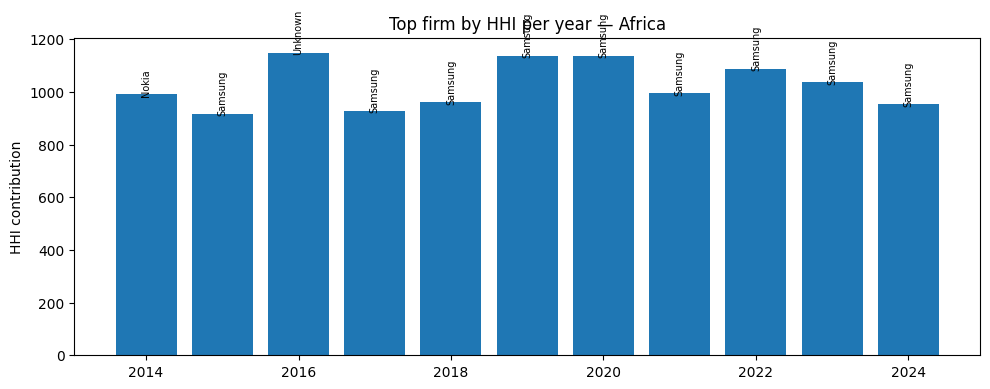

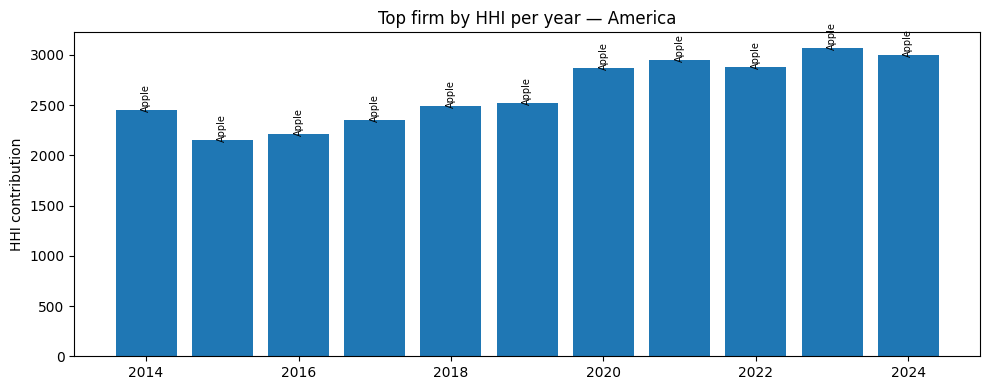

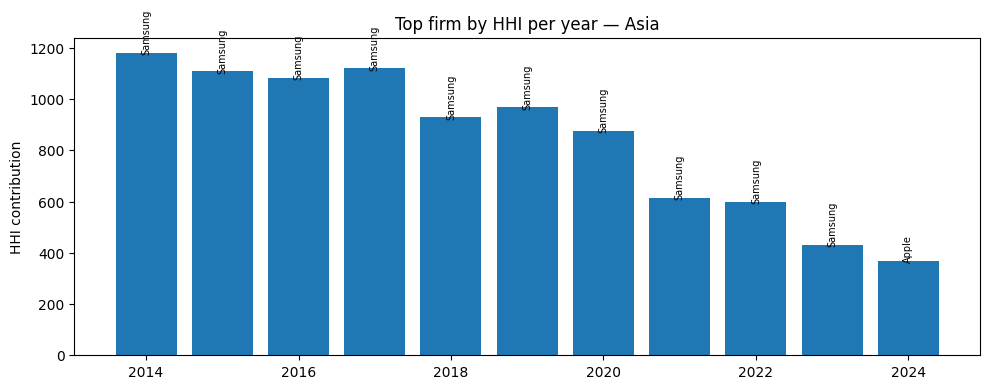

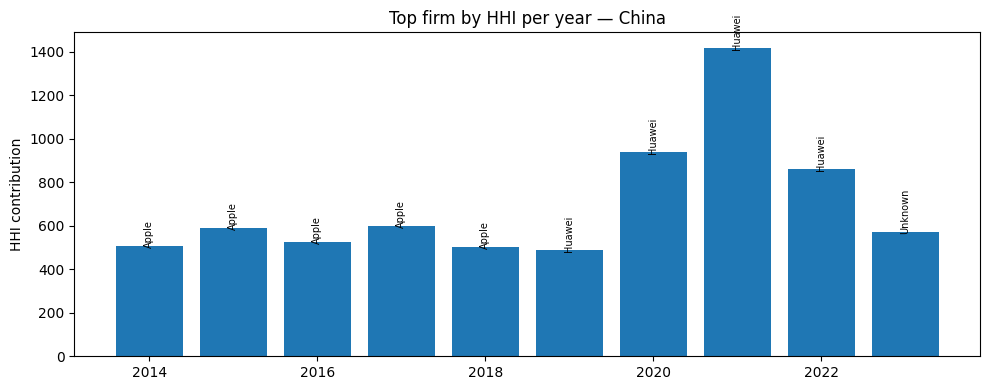

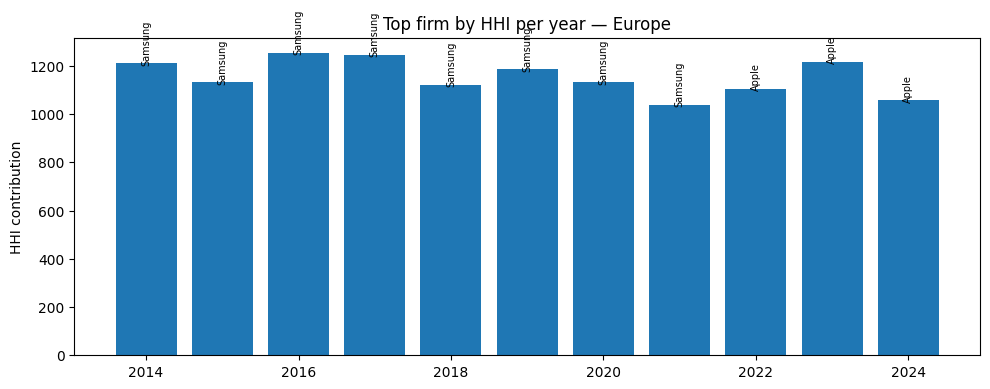

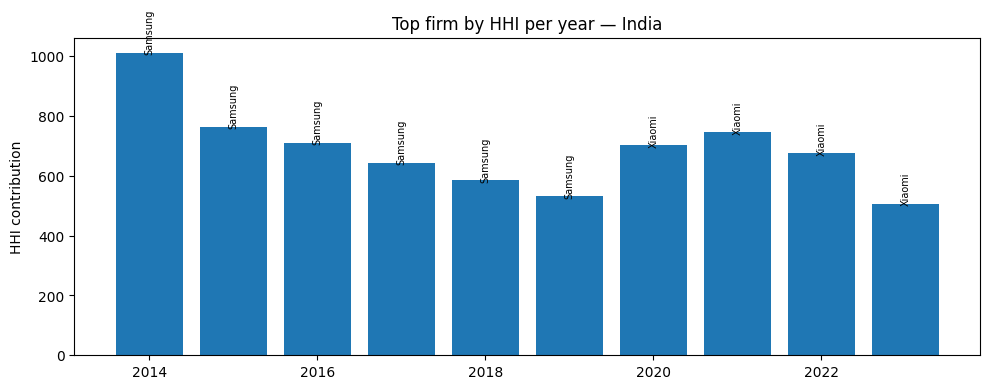

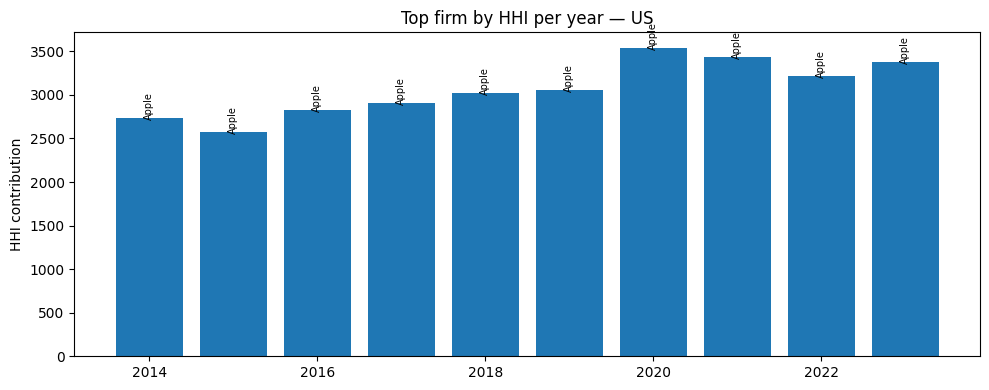

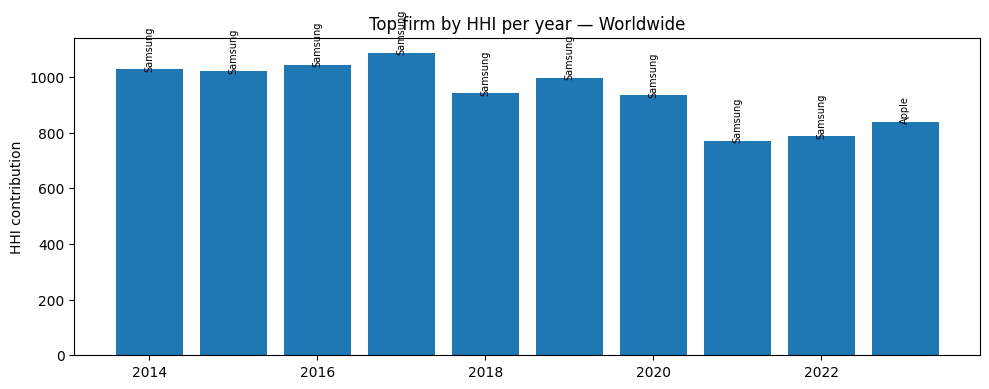

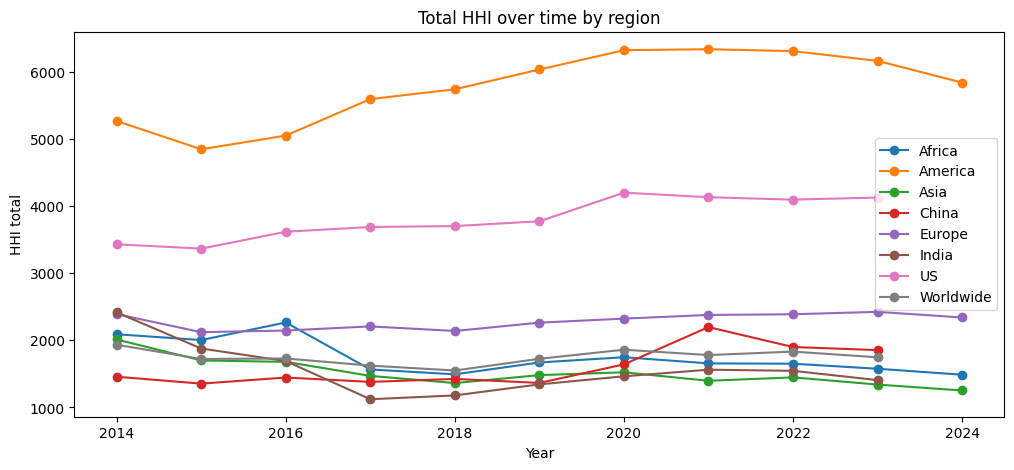

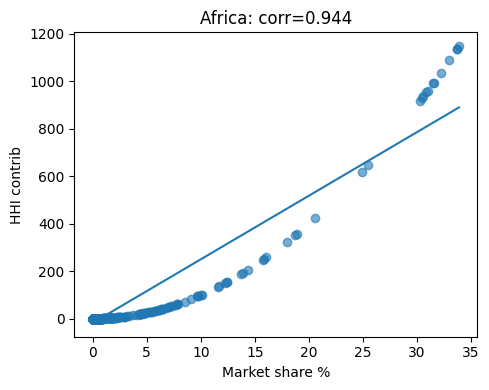

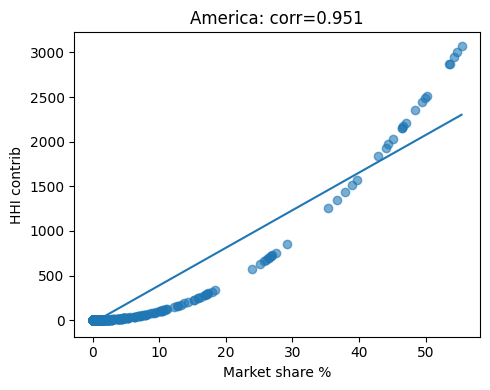

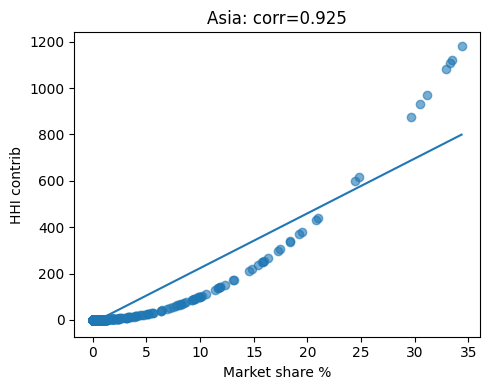

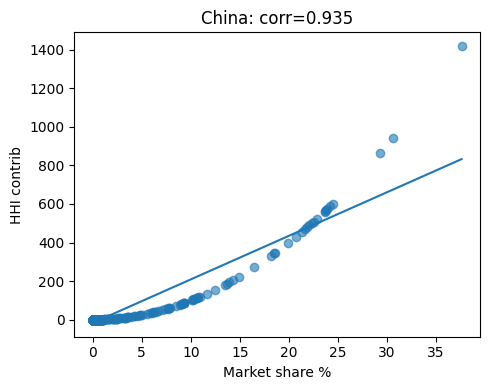

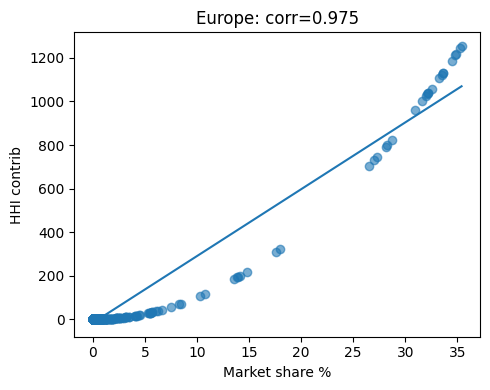

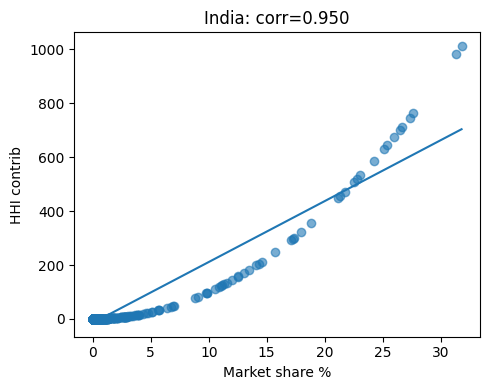

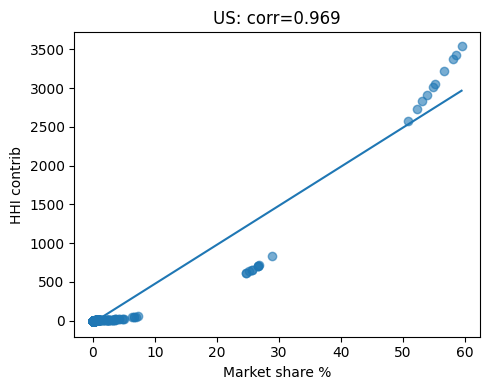

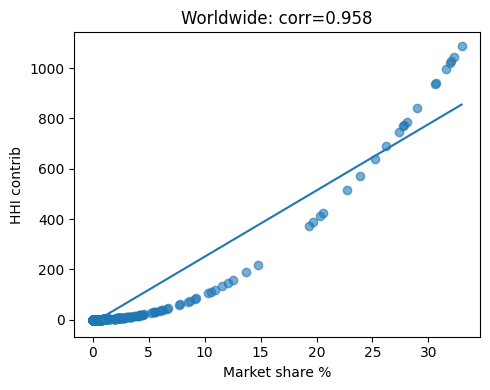

/tmp/ipykernel_1798/1421551568.py:77: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(year_col).apply(lambda g: pearsonr(g['Share_%'],g['HHI_contrib'])).reset_index(name='corr')
/tmp/ipykernel_1798/1421551568.py:77: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(year_col).apply(lambda g: pearsonr(g['Share_%'],g['HHI_contrib'])).reset_index(name='corr')
/tmp/ipykernel_1798/1421551568.p

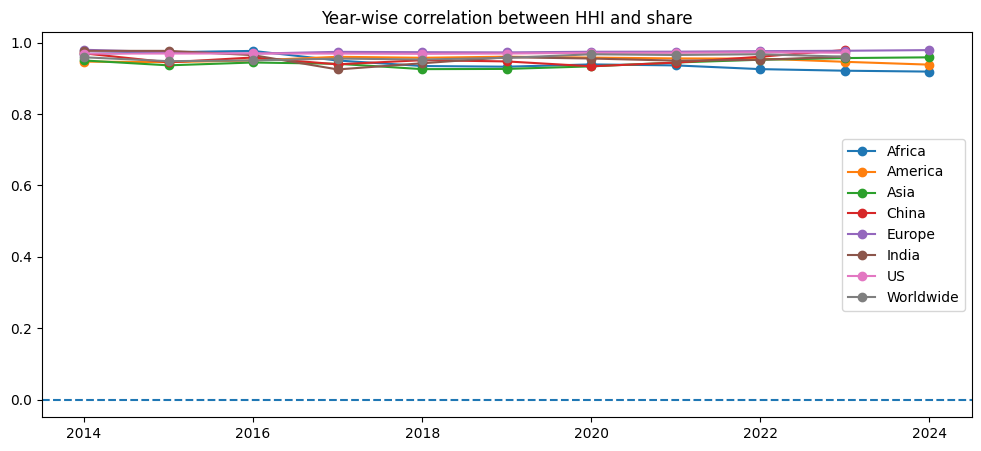

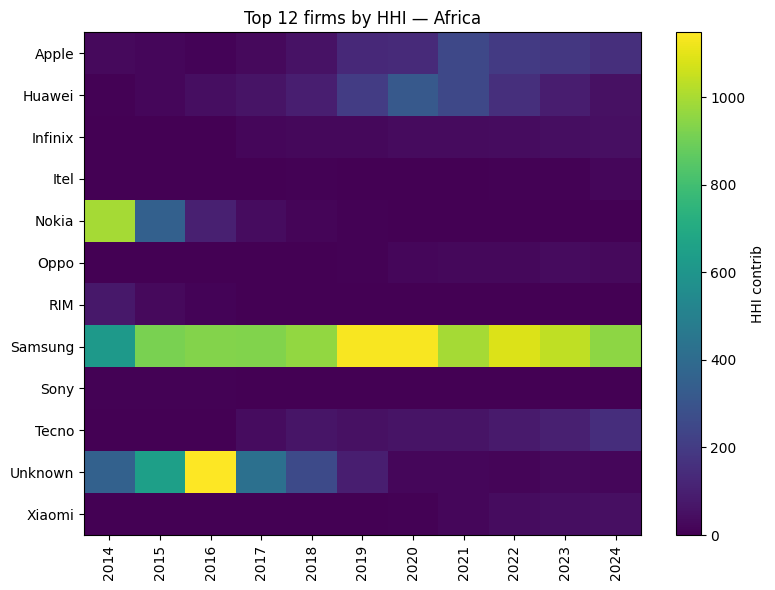

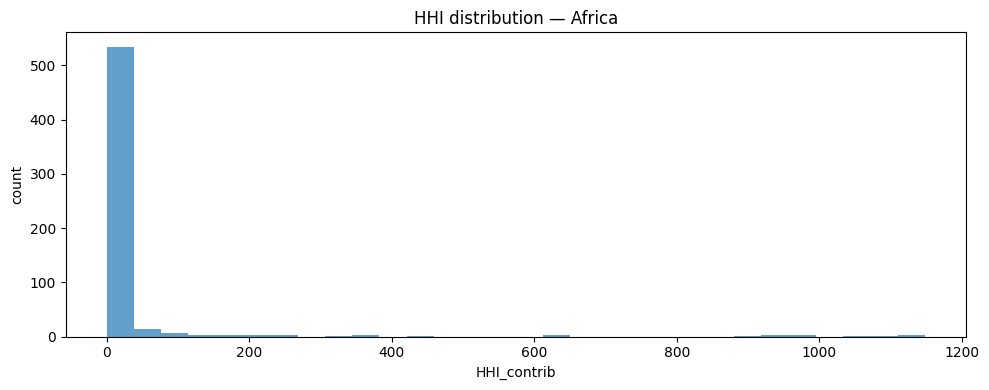

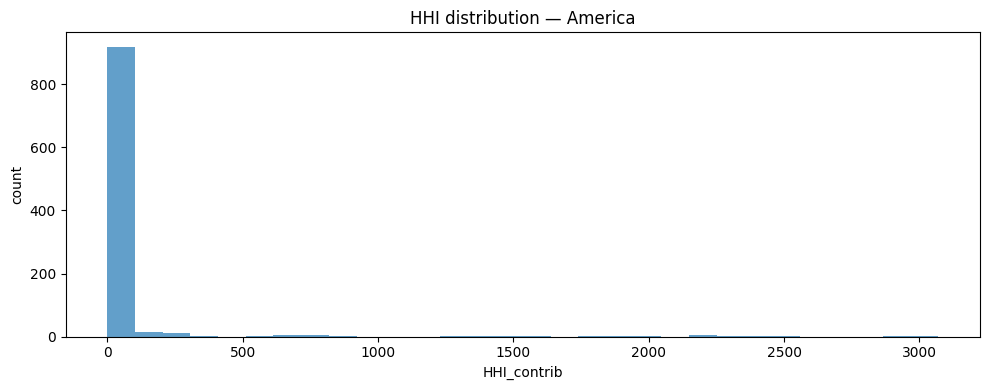

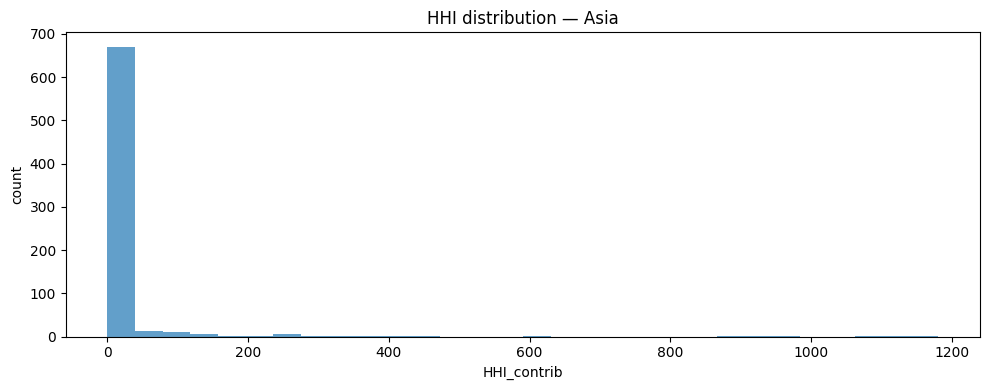

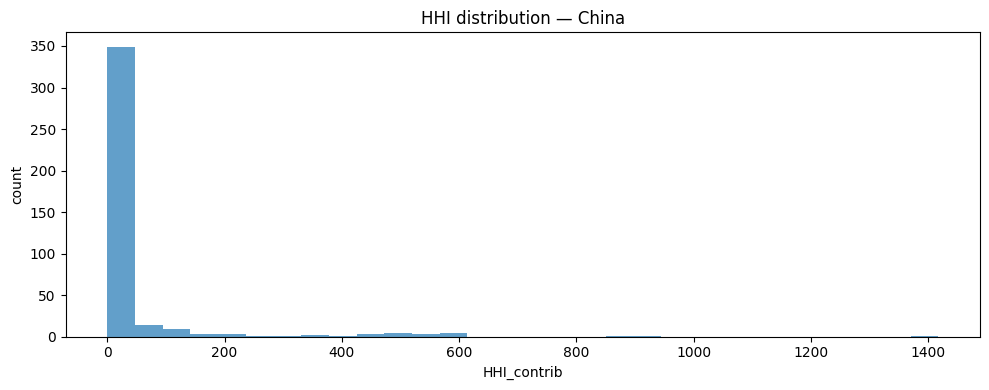

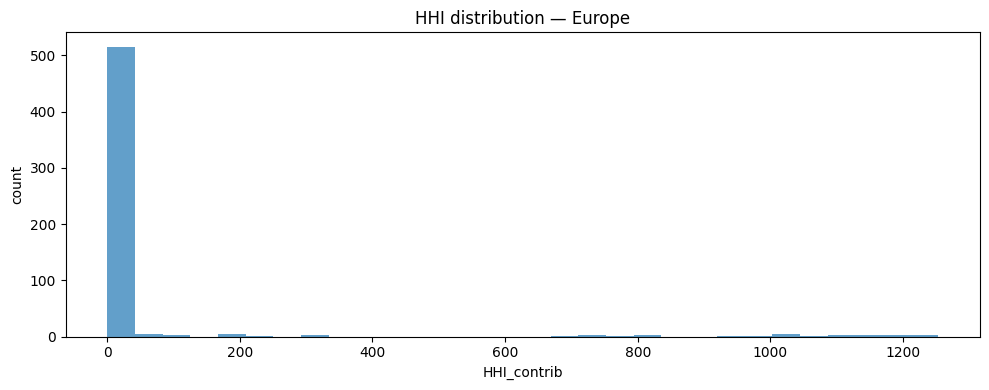

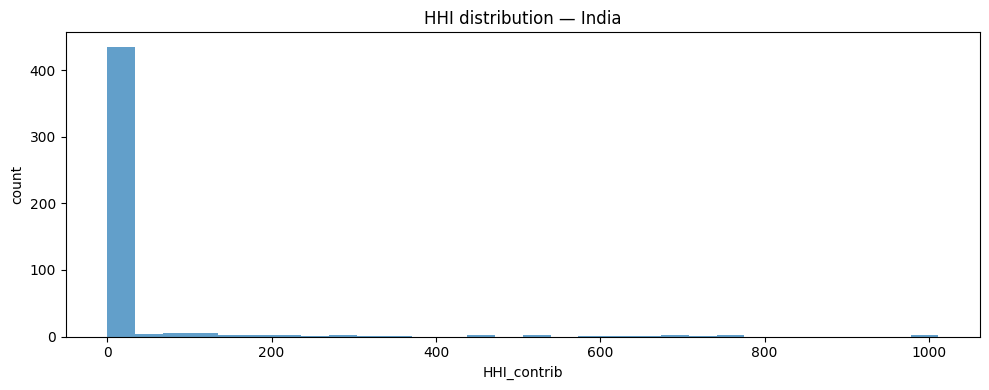

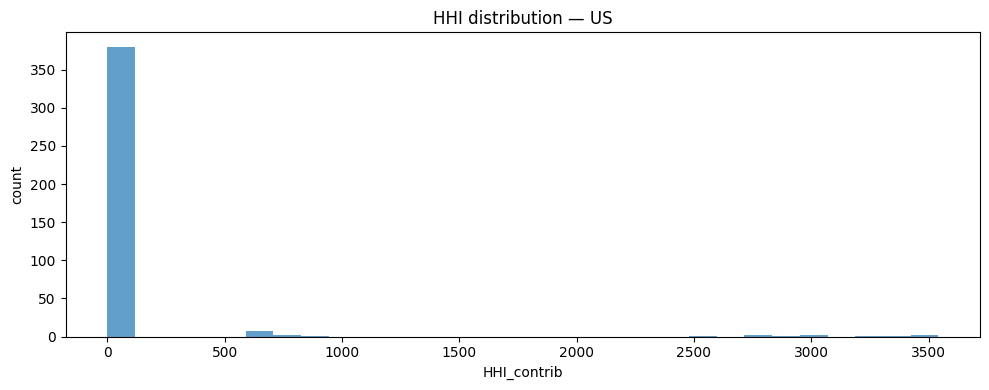

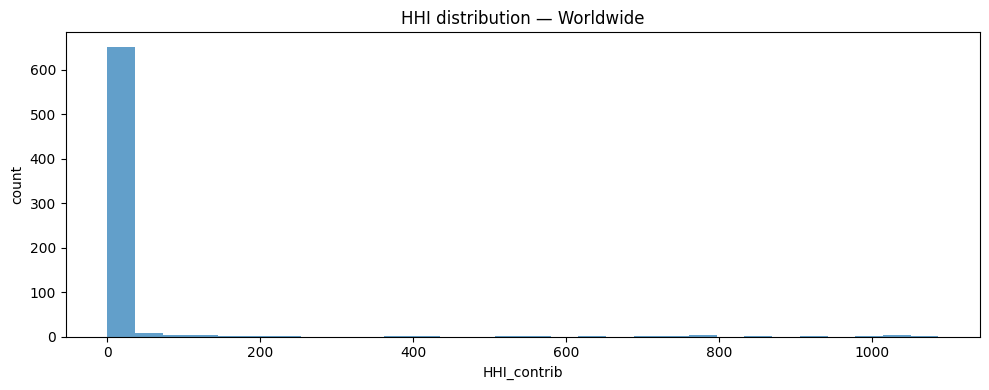

✅ Visualization suite done — all charts displayed.


In [27]:
! pip install openpyxl
"""
Visualization suite for HHI and market-share dynamics.
Reads automatically from HHI_FirmRegionYear.csv or HHI_mega.xlsx.
"""

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------------
# 0️⃣ Load best available dataset
# ---------------------------------------------------------------------------
if 'HHI_FirmRegionYear.csv' in [p.name for p in Path('.').iterdir()]:
    long = pd.read_csv('HHI_FirmRegionYear.csv')
elif Path('HHI_mega.xlsx').exists():
    long = pd.read_excel('HHI_mega.xlsx',sheet_name='FirmRegionYear')
else:
    raise FileNotFoundError("❌ No HHI data found. Run build_mega_hhi_exports.py first.")

# ---------------------------------------------------------------------------
# 1️⃣ Prep
# ---------------------------------------------------------------------------
year_col = 'Year' if 'Year' in long.columns else [c for c in long.columns if 'Year' in c][0]
company_col = 'Company' if 'Company' in long.columns else [c for c in long.columns if 'ompany' in c][0]
regions = sorted(long['Region'].dropna().unique().tolist())
long[year_col] = pd.to_numeric(long[year_col],errors='coerce')

# ---------------------------------------------------------------------------
# 2️⃣ Top firm by HHI each year × region
# ---------------------------------------------------------------------------
def plot_top_firm_by_year(region):
    d = long[long['Region']==region]
    idx = d.groupby(year_col)['HHI_contrib'].idxmax()
    top = d.loc[idx,[year_col,company_col,'HHI_contrib']]
    plt.figure(figsize=(10,4))
    plt.bar(top[year_col],top['HHI_contrib'])
    for _,r in top.iterrows():
        plt.text(r[year_col],r['HHI_contrib'],r[company_col],ha='center',rotation=90,fontsize=7)
    plt.title(f"Top firm by HHI per year — {region}")
    plt.ylabel("HHI contribution")
    plt.tight_layout(); plt.show()

for r in regions: plot_top_firm_by_year(r)

# ---------------------------------------------------------------------------
# 3️⃣ Regional HHI totals over time
# ---------------------------------------------------------------------------
tot = long.groupby([year_col,'Region'])['HHI_contrib'].sum().reset_index()
plt.figure(figsize=(12,5))
for r in regions:
    sub = tot[tot['Region']==r]
    plt.plot(sub[year_col],sub['HHI_contrib'],marker='o',label=r)
plt.title("Total HHI over time by region"); plt.xlabel("Year"); plt.ylabel("HHI total"); plt.legend(); plt.show()

# ---------------------------------------------------------------------------
# 4️⃣ Scatter & correlation HHI vs share
# ---------------------------------------------------------------------------
def pearsonr(x,y):
    if len(x)<3: return np.nan
    return np.corrcoef(x,y)[0,1]

for r in regions:
    sub = long[long['Region']==r]
    r_val = pearsonr(sub['Share_%'],sub['HHI_contrib'])
    plt.figure(figsize=(5,4))
    plt.scatter(sub['Share_%'],sub['HHI_contrib'],alpha=0.6)
    m,b=np.polyfit(sub['Share_%'],sub['HHI_contrib'],1)
    xs=np.linspace(sub['Share_%'].min(),sub['Share_%'].max(),100)
    plt.plot(xs,m*xs+b)
    plt.title(f"{r}: corr={r_val:.3f}")
    plt.xlabel("Market share %"); plt.ylabel("HHI contrib"); plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------------
# 5️⃣ Year-wise correlation evolution
# ---------------------------------------------------------------------------
def corr_by_year(df):
    return df.groupby(year_col).apply(lambda g: pearsonr(g['Share_%'],g['HHI_contrib'])).reset_index(name='corr')

plt.figure(figsize=(12,5))
for r in regions:
    sub=corr_by_year(long[long['Region']==r])
    plt.plot(sub[year_col],sub['corr'],marker='o',label=r)
plt.axhline(0,ls='--'); plt.title("Year-wise correlation between HHI and share"); plt.legend(); plt.show()

# ---------------------------------------------------------------------------
# 6️⃣ Heatmap of top firms by HHI (choose region)
# ---------------------------------------------------------------------------
REGION_FOCUS = regions[0]
TOP_N=12
sub = long[long['Region']==REGION_FOCUS]
top=sub.groupby(company_col)['HHI_contrib'].sum().nlargest(TOP_N).index
mat=sub[sub[company_col].isin(top)].pivot(index=company_col,columns=year_col,values='HHI_contrib').fillna(0)
plt.figure(figsize=(max(8,len(mat.columns)*0.6),6))
plt.imshow(mat,aspect='auto'); plt.colorbar(label='HHI contrib')
plt.xticks(range(len(mat.columns)),mat.columns,rotation=90)
plt.yticks(range(len(mat.index)),mat.index)
plt.title(f"Top {TOP_N} firms by HHI — {REGION_FOCUS}")
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------------
# 7️⃣ Distributions
# ---------------------------------------------------------------------------
for r in regions:
    sub=long[long['Region']==r]
    plt.figure(figsize=(10,4))
    plt.hist(sub['HHI_contrib'],bins=30,alpha=.7)
    plt.title(f"HHI distribution — {r}"); plt.xlabel("HHI_contrib"); plt.ylabel("count"); plt.tight_layout(); plt.show()

print("✅ Visualization suite done — all charts displayed.")


### Concentration Ration CRn

✅ Metrics computed for 8 regions.


/tmp/ipykernel_1798/3717158810.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long = long.groupby("Region", group_keys=False).apply(detect_and_scale)
/tmp/ipykernel_1798/3717158810.py:85: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = long.groupby([year_col, "Region"]).apply(compute_metrics).reset_index()


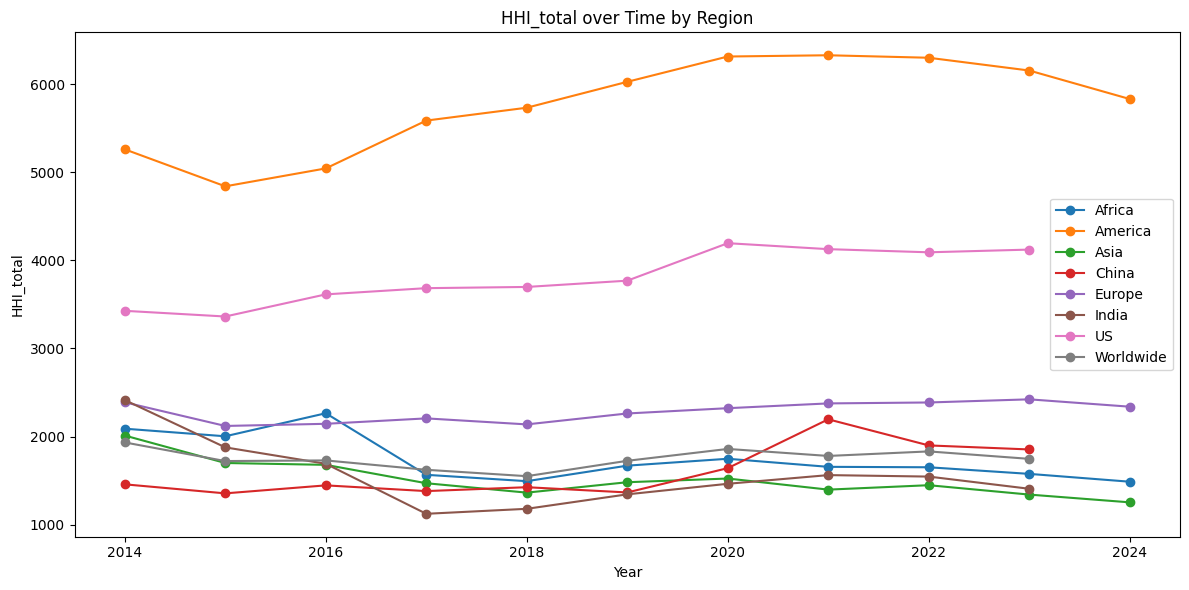

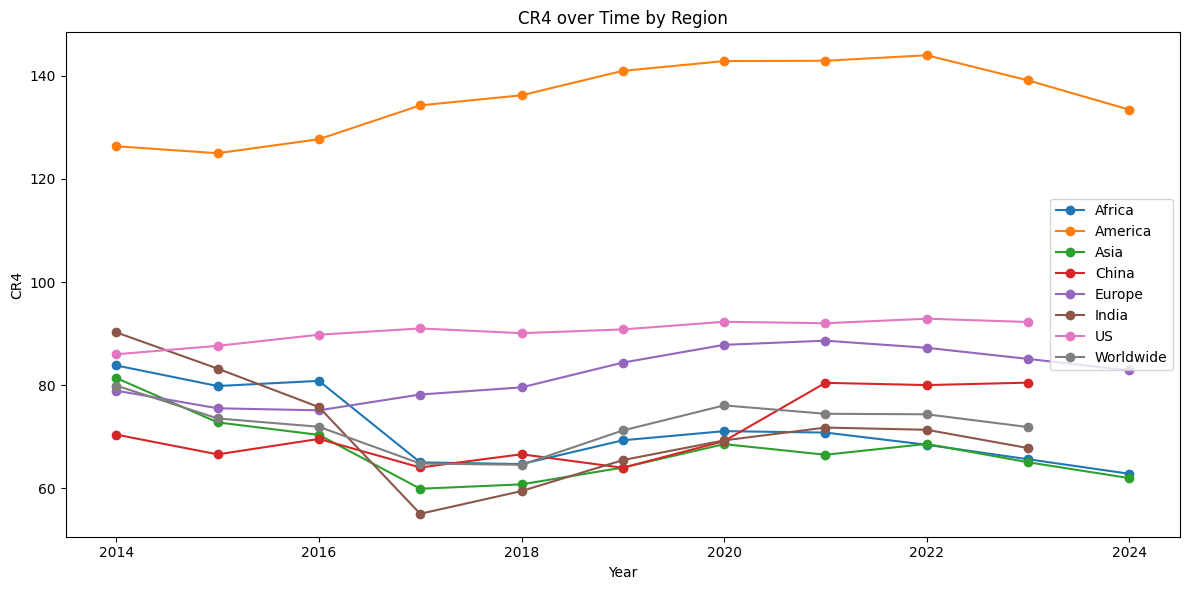

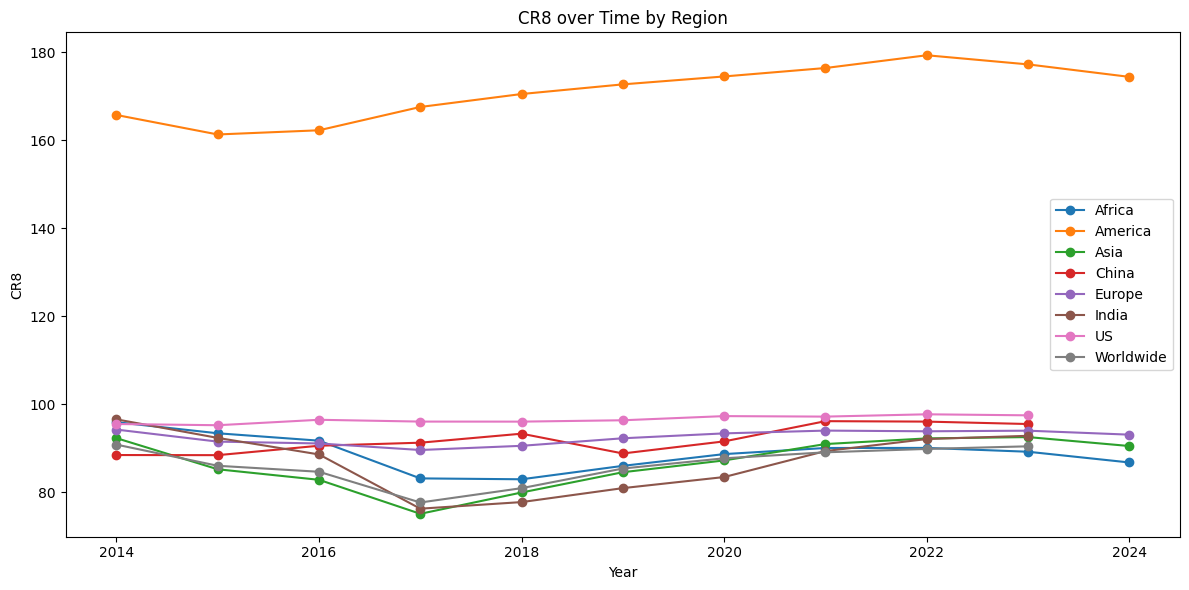

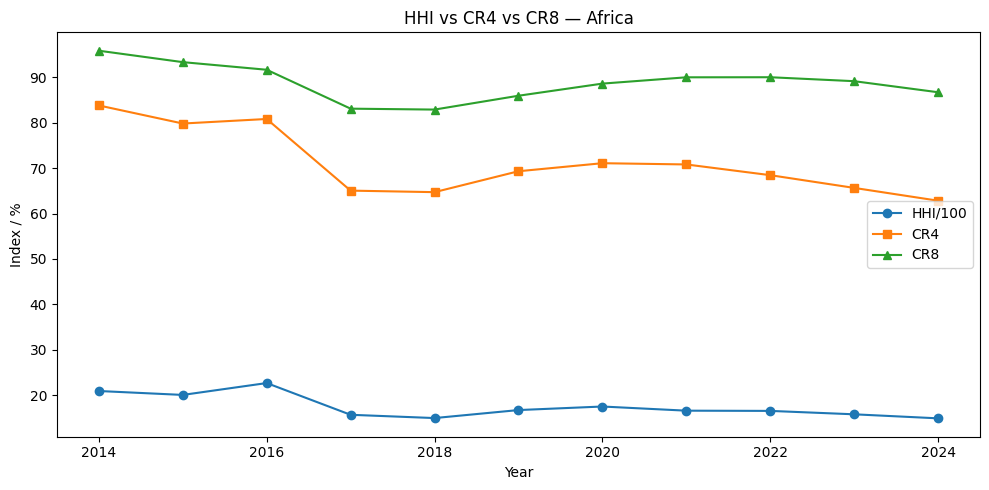

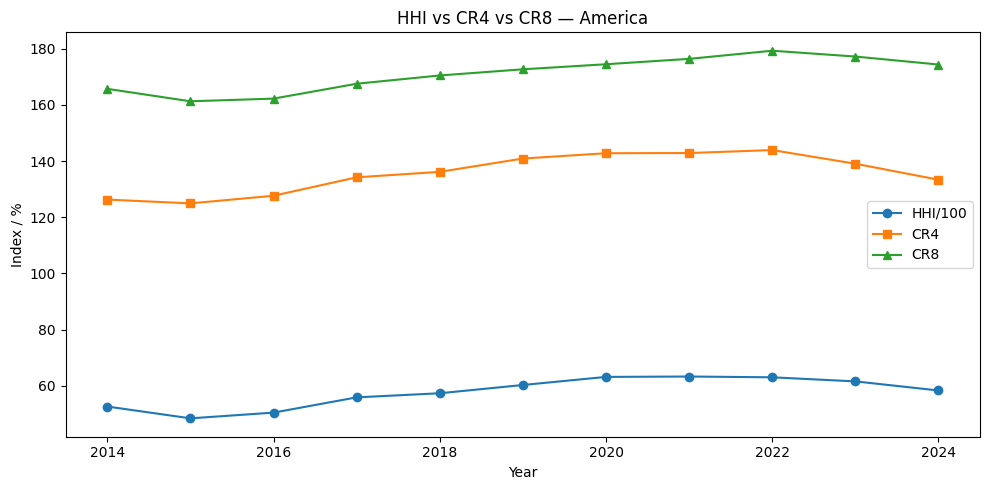

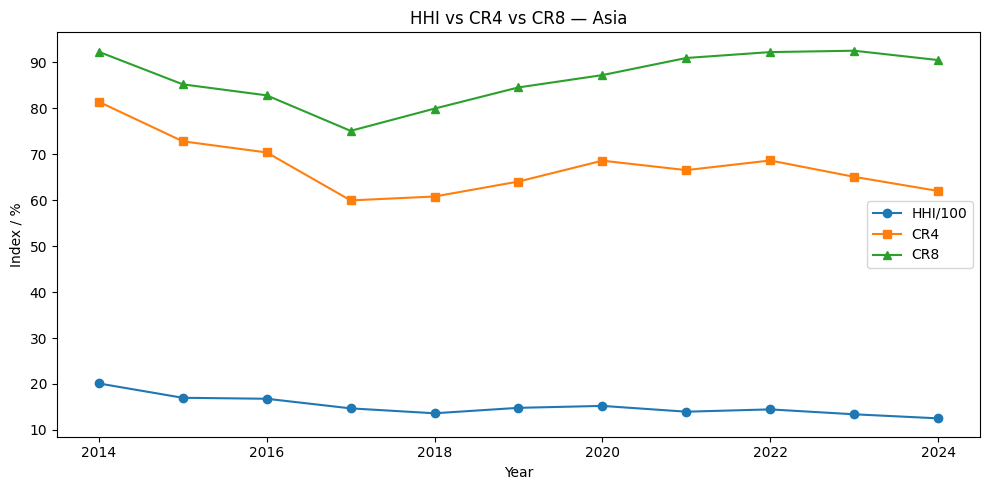

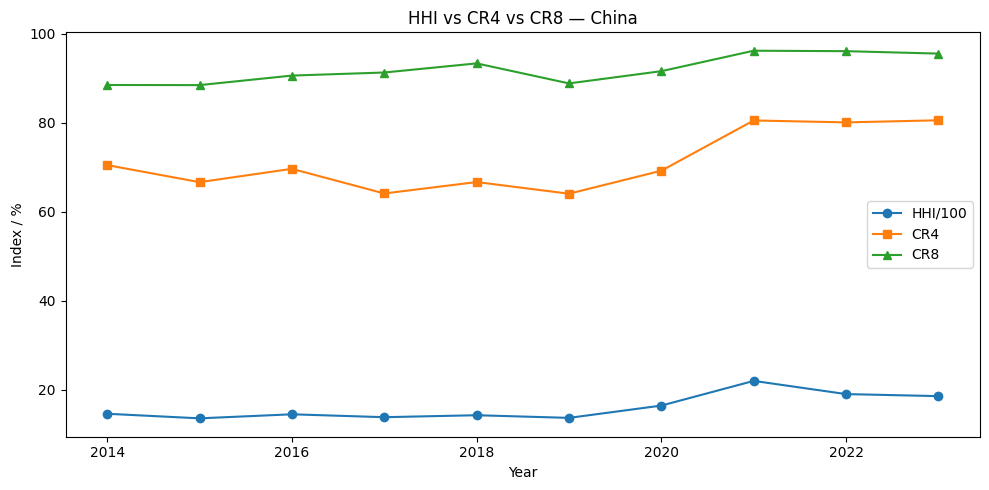

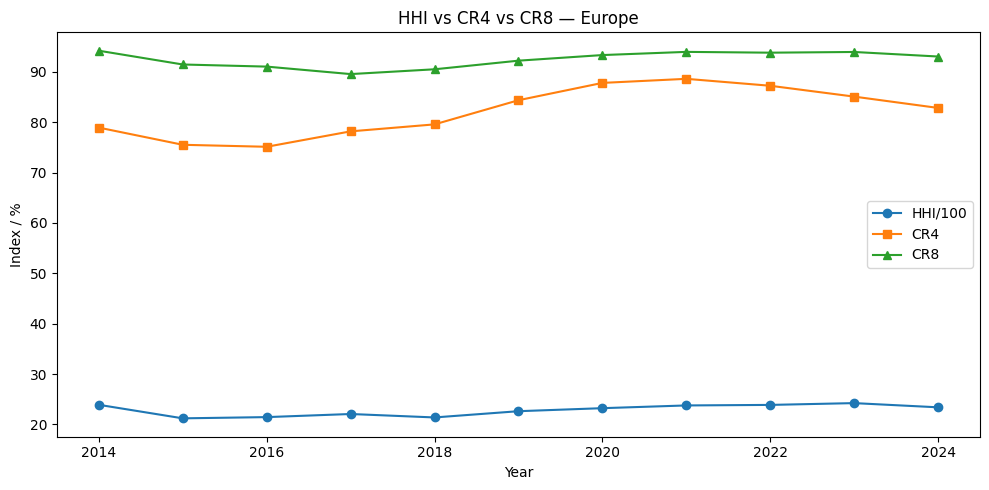

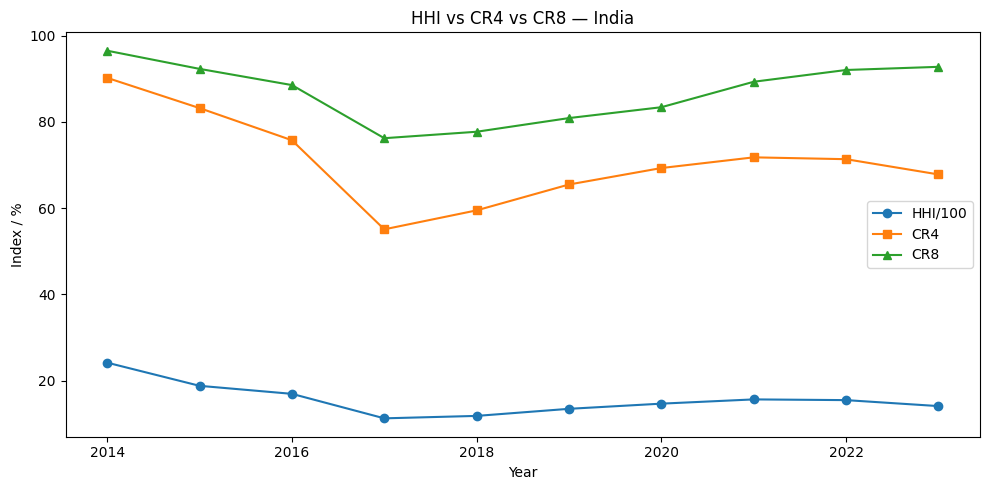

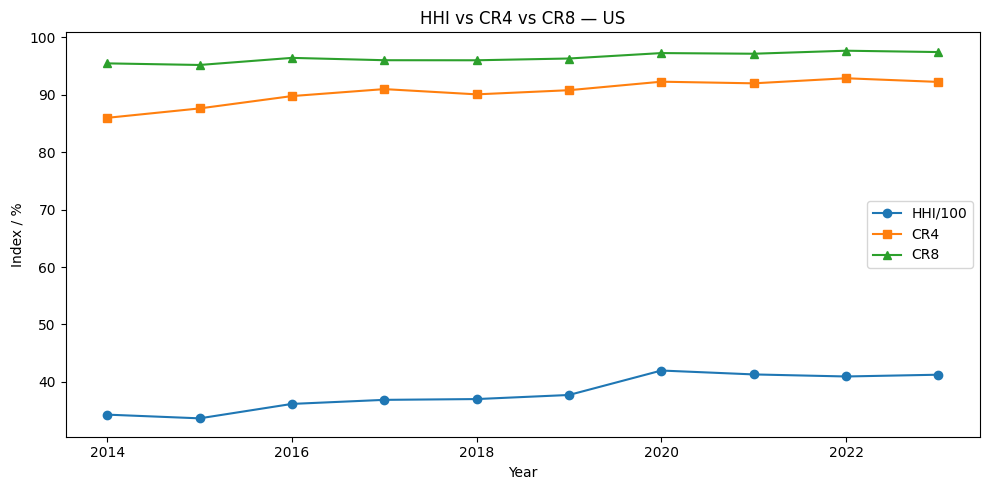

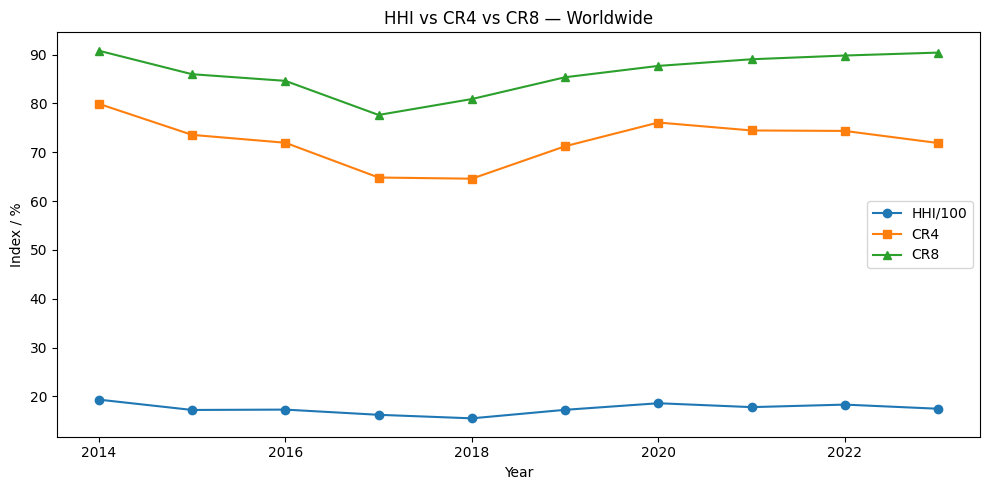

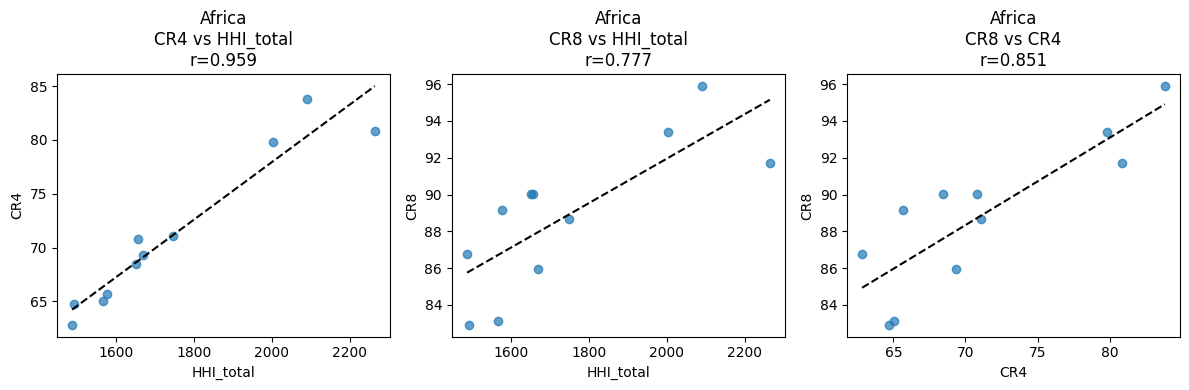

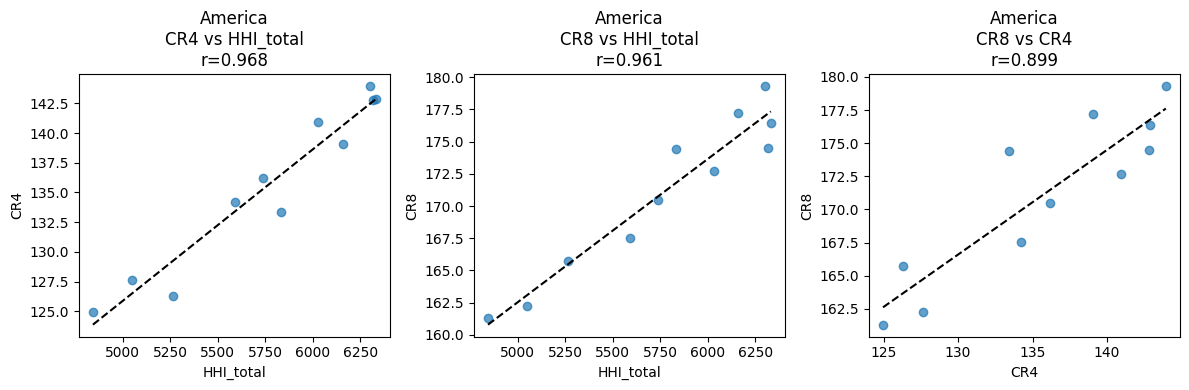

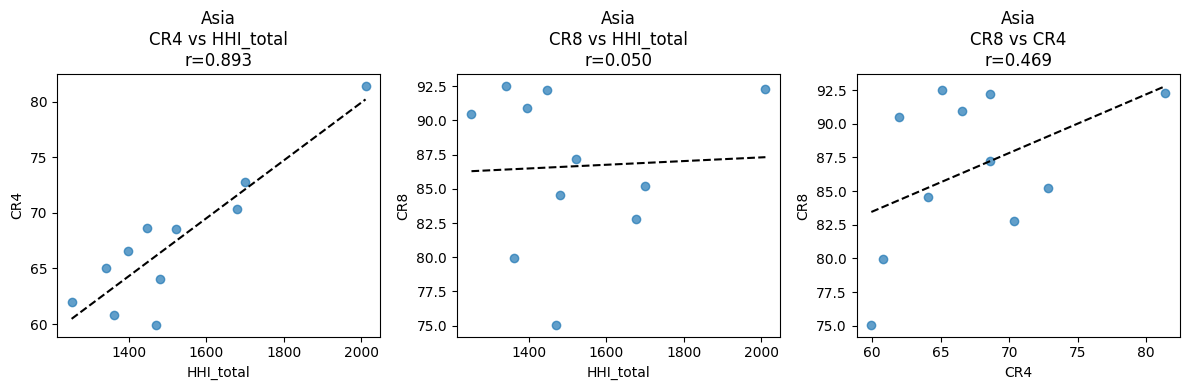

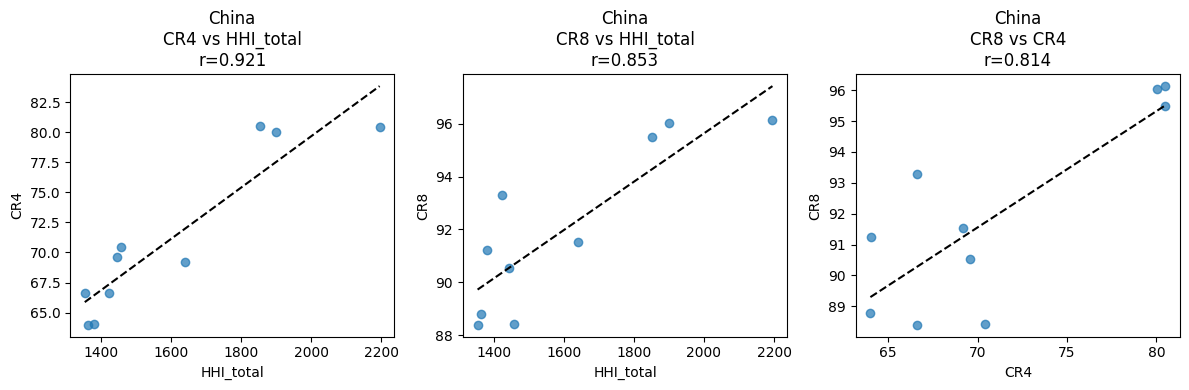

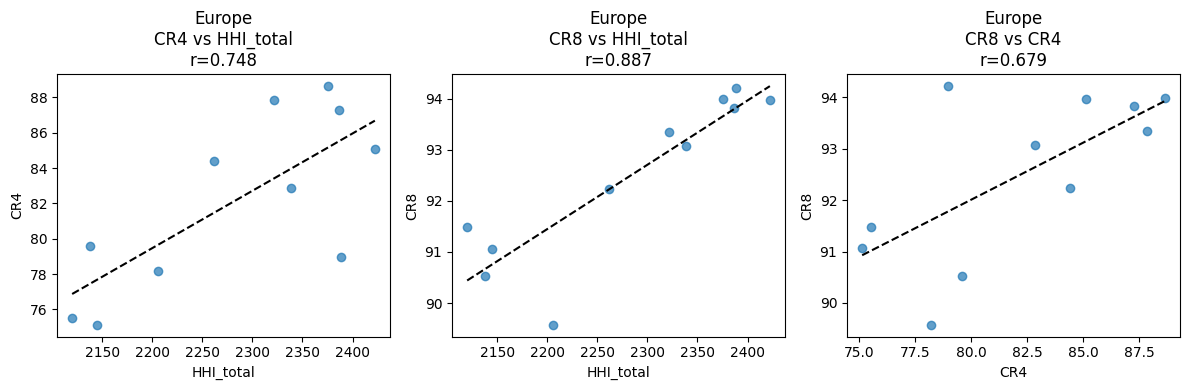

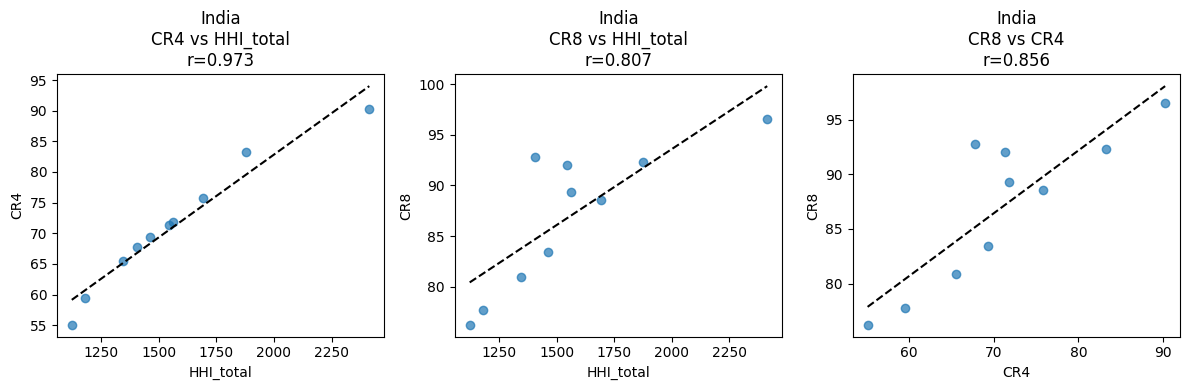

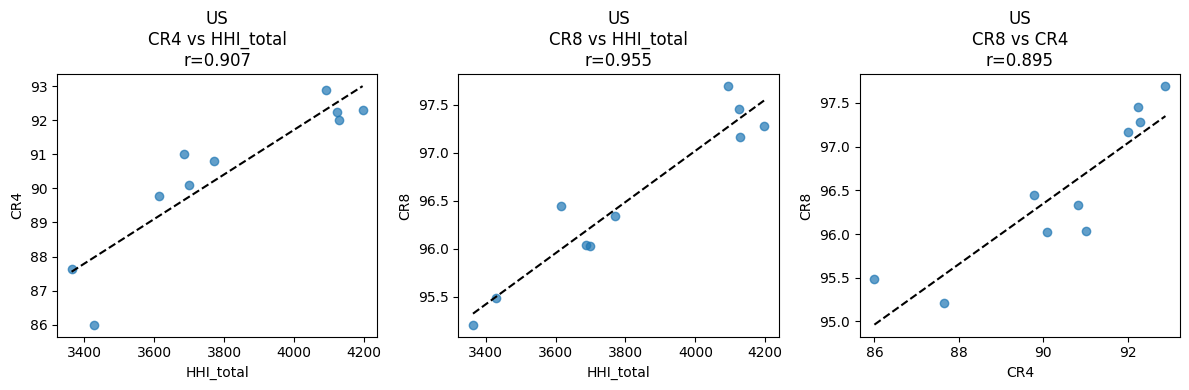

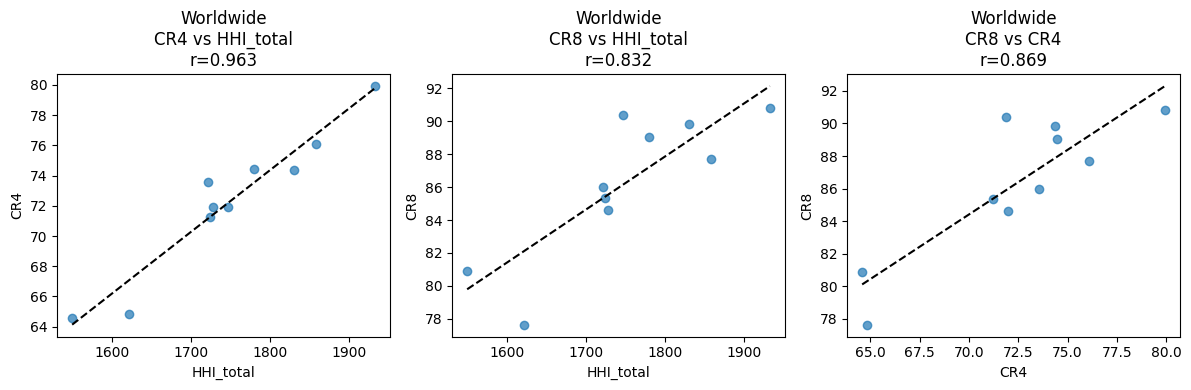

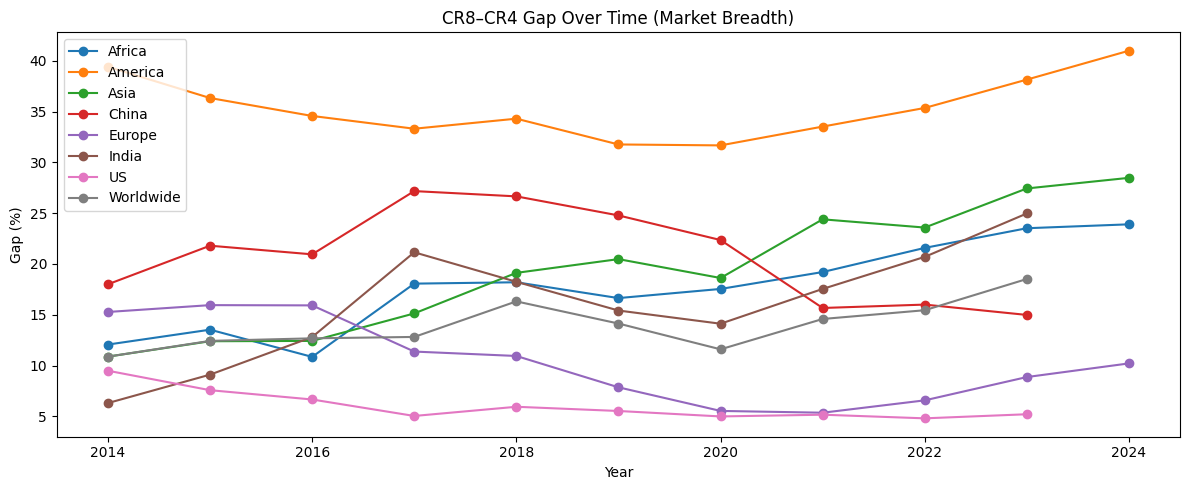

In [28]:
"""
Comprehensive analysis of HHI, CR4, and CR8 using market_share_all.

Steps:
1. Clean and reshape data.
2. Compute HHI, CR4, and CR8 per region-year.
3. Produce visualizations:
   - Trends over time
   - Pairwise correlations
   - Scatterplots
   - CR8–CR4 gap
   - Rolling correlations
   - Heatmaps
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# --------------------------------------------------------------------
# 1️⃣ LOAD AND CLEAN
# --------------------------------------------------------------------
try:
    df_raw = market_share_all.copy()
except NameError:
    raise NameError("❌ Variable 'market_share_all' not found in memory.")

def pick_first(cols, names):
    for n in names:
        if n in cols:
            return n
    lower = {c.lower(): c for c in cols}
    for n in names:
        if n.lower() in lower:
            return lower[n.lower()]
    return None

cols = list(df_raw.columns)
year_col = pick_first(cols, ["Year", "year", "YEAR"])
company_col = pick_first(cols, ["Company", "Company Name", "Firm", "Brand", "Brand Name"])
region_cols = [c for c in cols if str(c).startswith("Market Share")]

if not year_col or not company_col or not region_cols:
    raise ValueError("Missing expected columns. Must have Year, Company, and Market Share region columns.")

df = df_raw[[year_col, company_col] + region_cols].copy()
df = df.dropna(how="all", subset=region_cols)
df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
df = df.dropna(subset=[year_col])
df[company_col] = df[company_col].astype(str).str.strip()

# --------------------------------------------------------------------
# 2️⃣ LONG FORMAT + SCALE SHARES
# --------------------------------------------------------------------
long = df.melt(
    id_vars=[year_col, company_col],
    value_vars=region_cols,
    var_name="RegionCol",
    value_name="Share_raw",
).dropna(subset=["Share_raw"])

long["Region"] = long["RegionCol"].str.split().str[-1]
long["Share_raw"] = pd.to_numeric(long["Share_raw"], errors="coerce")
long = long.dropna(subset=["Share_raw"])

def detect_and_scale(g):
    p95 = np.nanpercentile(g["Share_raw"], 95)
    g["Share_%"] = g["Share_raw"] * 100 if p95 <= 1 else g["Share_raw"]
    return g

long = long.groupby("Region", group_keys=False).apply(detect_and_scale)
long = long[long["Share_%"] >= 0]

# --------------------------------------------------------------------
# 3️⃣ CALCULATE HHI, CR4, CR8
# --------------------------------------------------------------------
def compute_metrics(g):
    g_sorted = g.sort_values("Share_%", ascending=False)
    hhi = (g_sorted["Share_%"] ** 2).sum()
    cr4 = g_sorted["Share_%"].head(4).sum()
    cr8 = g_sorted["Share_%"].head(8).sum()
    return pd.Series({"HHI_total": hhi, "CR4": cr4, "CR8": cr8})

metrics = long.groupby([year_col, "Region"]).apply(compute_metrics).reset_index()

# Merge back for easier cross-analysis
merged = long.merge(metrics, on=[year_col, "Region"], how="left")

regions = sorted(metrics["Region"].unique())
print(f"✅ Metrics computed for {len(regions)} regions.")

# --------------------------------------------------------------------
# 4️⃣ VISUALIZATIONS
# --------------------------------------------------------------------

# ---- A. HHI, CR4, CR8 Trends Over Time ----
for metric in ["HHI_total", "CR4", "CR8"]:
    plt.figure(figsize=(12, 6))
    for region in regions:
        sub = metrics[metrics["Region"] == region]
        plt.plot(sub[year_col], sub[metric], marker="o", label=region)
    plt.title(f"{metric} over Time by Region")
    plt.xlabel("Year")
    plt.ylabel(metric)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- B. Comparative Plot (All 3 Metrics) ----
for region in regions:
    sub = metrics[metrics["Region"] == region].sort_values(year_col)
    plt.figure(figsize=(10, 5))
    plt.plot(sub[year_col], sub["HHI_total"] / 100, label="HHI/100", marker="o")
    plt.plot(sub[year_col], sub["CR4"], label="CR4", marker="s")
    plt.plot(sub[year_col], sub["CR8"], label="CR8", marker="^")
    plt.title(f"HHI vs CR4 vs CR8 — {region}")
    plt.xlabel("Year")
    plt.ylabel("Index / %")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- C. Pairwise Scatter + Correlations ----
pairs = list(combinations(["HHI_total", "CR4", "CR8"], 2))
for region in regions:
    sub = metrics[metrics["Region"] == region]
    plt.figure(figsize=(12, 4))
    for i, (x, y) in enumerate(pairs, 1):
        plt.subplot(1, 3, i)
        plt.scatter(sub[x], sub[y], alpha=0.7)
        if len(sub) > 2:
            m, b = np.polyfit(sub[x], sub[y], 1)
            xs = np.linspace(sub[x].min(), sub[x].max(), 100)
            plt.plot(xs, m * xs + b, color="black", linestyle="--")
        r = np.corrcoef(sub[x], sub[y])[0, 1]
        plt.title(f"{region}\n{y} vs {x}\nr={r:.3f}")
        plt.xlabel(x)
        plt.ylabel(y)
    plt.tight_layout()
    plt.show()

# ---- D. CR8–CR4 Gap ----
plt.figure(figsize=(12, 5))
for region in regions:
    sub = metrics[metrics["Region"] == region]
    plt.plot(sub[year_col], sub["CR8"] - sub["CR4"], marker="o", label=region)
plt.title("CR8–CR4 Gap Over Time (Market Breadth)")
plt.xlabel("Year")
plt.ylabel("Gap (%)")
plt.legend()
plt.tight_layout()
plt.show()



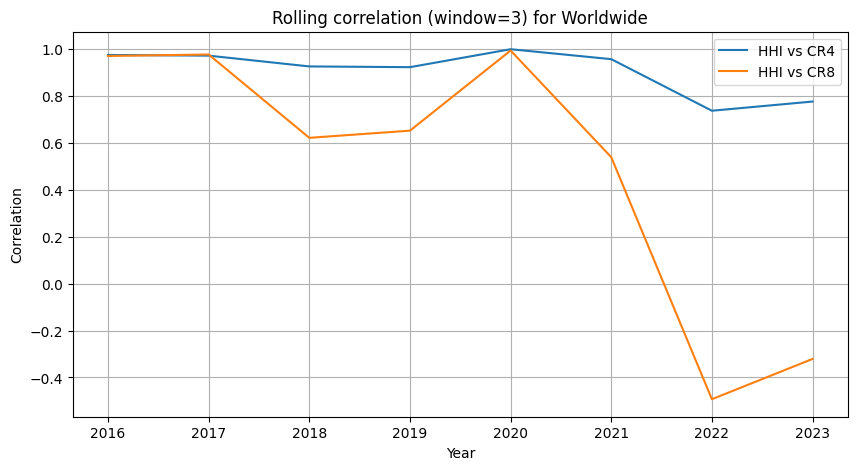


 Correlation Matrix — Africa
           HHI_total    CR4    CR8
HHI_total      1.000  0.959  0.777
CR4            0.959  1.000  0.851
CR8            0.777  0.851  1.000

 Correlation Matrix — America
           HHI_total    CR4    CR8
HHI_total      1.000  0.968  0.961
CR4            0.968  1.000  0.899
CR8            0.961  0.899  1.000

 Correlation Matrix — Asia
           HHI_total    CR4    CR8
HHI_total      1.000  0.893  0.050
CR4            0.893  1.000  0.469
CR8            0.050  0.469  1.000

 Correlation Matrix — China
           HHI_total    CR4    CR8
HHI_total      1.000  0.921  0.853
CR4            0.921  1.000  0.814
CR8            0.853  0.814  1.000

 Correlation Matrix — Europe
           HHI_total    CR4    CR8
HHI_total      1.000  0.748  0.887
CR4            0.748  1.000  0.679
CR8            0.887  0.679  1.000

 Correlation Matrix — India
           HHI_total    CR4    CR8
HHI_total      1.000  0.973  0.807
CR4            0.973  1.000  0.856
CR8            0.8

In [29]:
sub = metrics[metrics["Region"] == region].sort_values(year_col)

# Check required columns exist
required_cols = {"HHI_total", "CR4", "CR8"}
missing = required_cols - set(sub.columns)
if missing:
    raise KeyError(f"Missing columns in data: {missing}")

# Compute rolling correlations directly (simpler and faster)
corr_HHI_CR4 = sub["HHI_total"].rolling(window).corr(sub["CR4"])
corr_HHI_CR8 = sub["HHI_total"].rolling(window).corr(sub["CR8"])

plt.figure(figsize=(10, 5))
plt.plot(sub[year_col], corr_HHI_CR4, label="HHI vs CR4")
plt.plot(sub[year_col], corr_HHI_CR8, label="HHI vs CR8")
plt.title(f"Rolling correlation (window={window}) for {region}")
plt.xlabel(year_col)
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)
plt.show()


# ---- G. Correlation Matrix per Region (Numeric) ----
for region in regions:
    sub = metrics[metrics["Region"] == region][["HHI_total", "CR4", "CR8"]]
    corr = sub.corr()
    print(f"\n Correlation Matrix — {region}")
    print(corr.round(3))

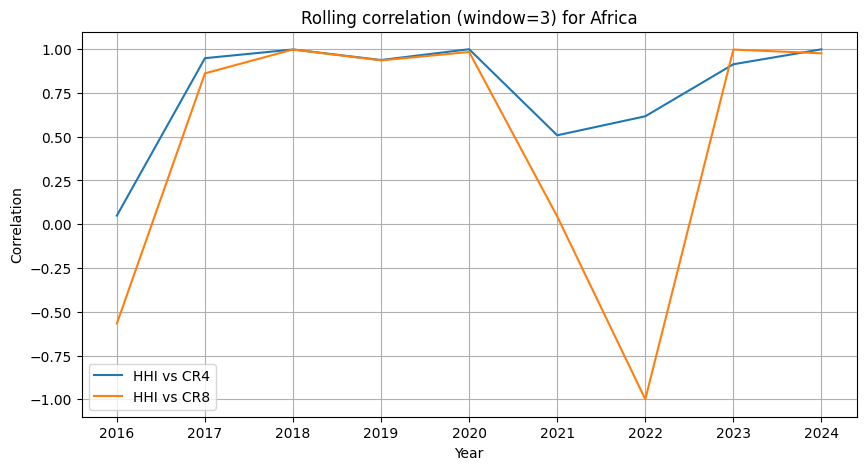

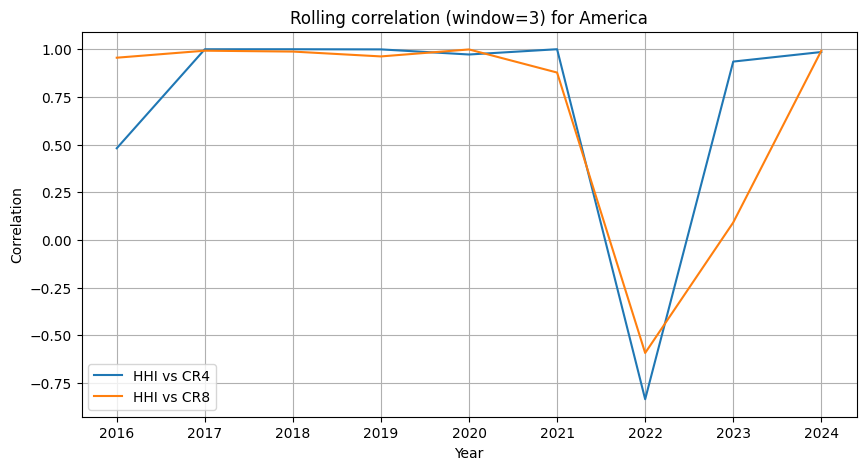

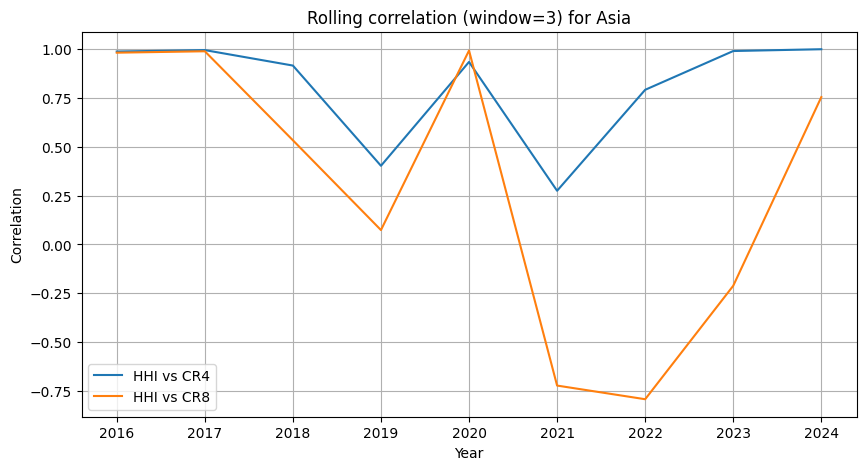

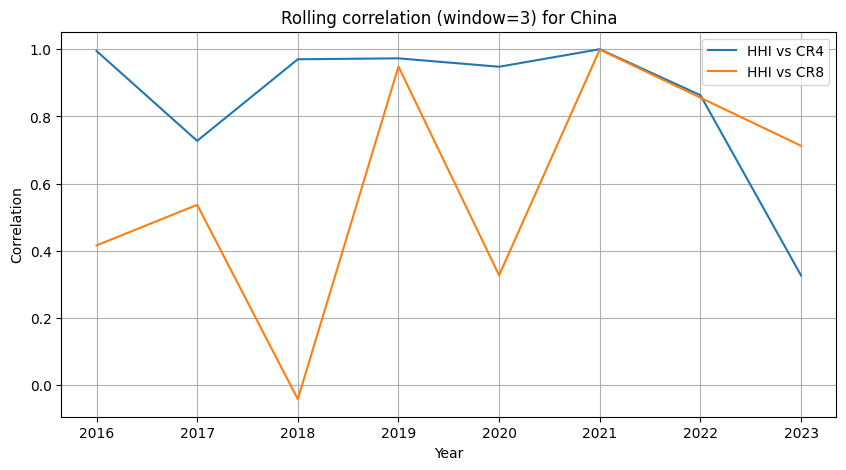

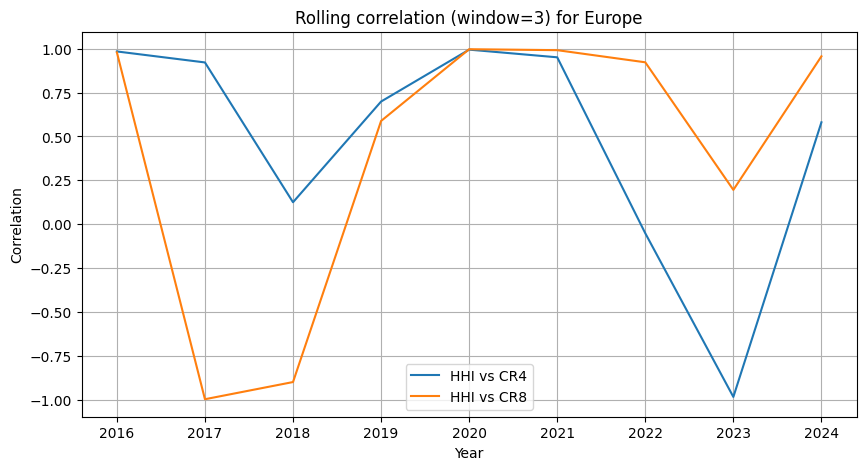

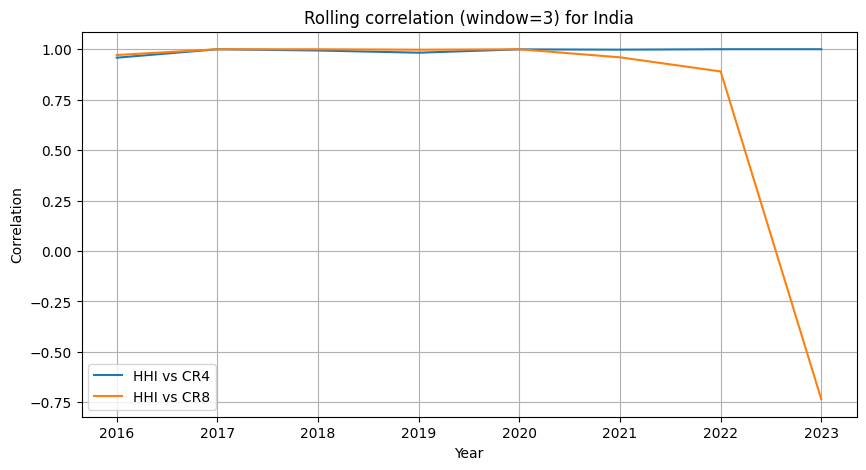

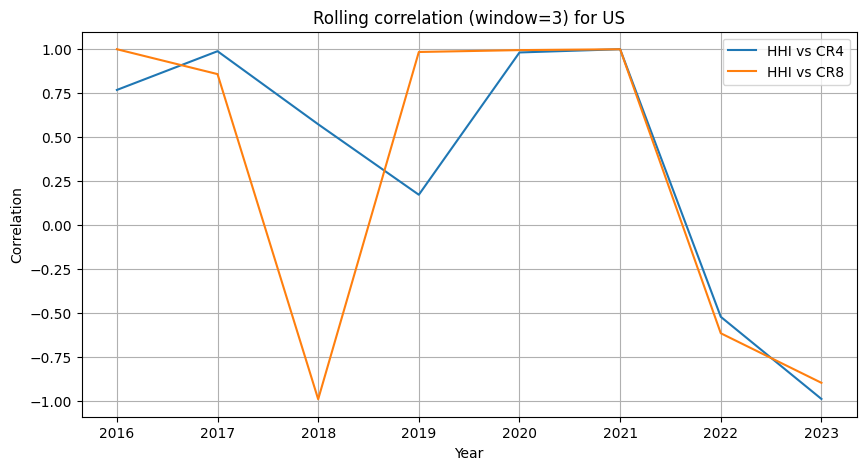

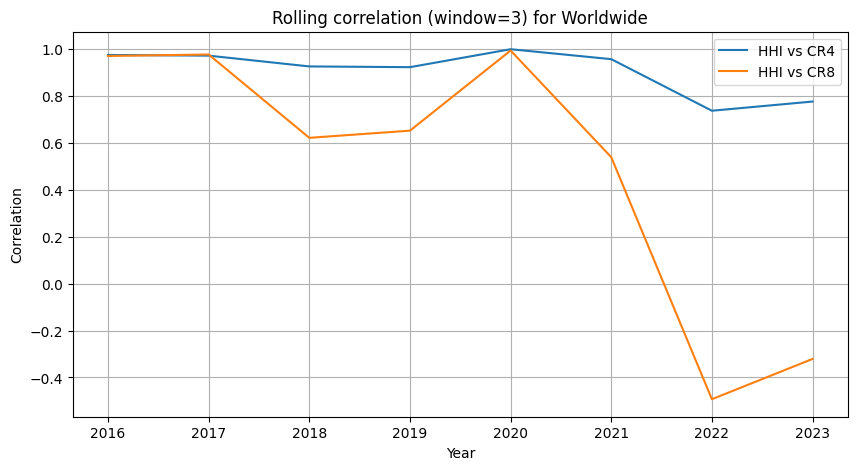

✅ Rolling correlation results saved to 'rolling_correlations.xlsx'


In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare a list to collect all results
results = []

# Loop through each region
for region in metrics["Region"].unique():
    sub = metrics[metrics["Region"] == region].sort_values(year_col)

    # Check required columns
    required_cols = {"HHI_total", "CR4", "CR8"}
    missing = required_cols - set(sub.columns)
    if missing:
        print(f"⚠️ Skipping {region}: missing columns {missing}")
        continue

    # Compute rolling correlations directly
    corr_HHI_CR4 = sub["HHI_total"].rolling(window).corr(sub["CR4"])
    corr_HHI_CR8 = sub["HHI_total"].rolling(window).corr(sub["CR8"])

    # Store results for Excel export
    temp = pd.DataFrame({
        "Region": region,
        year_col: sub[year_col],
        "corr_HHI_CR4": corr_HHI_CR4,
        "corr_HHI_CR8": corr_HHI_CR8
    })
    results.append(temp)

    # Optional: Plot
    plt.figure(figsize=(10, 5))
    plt.plot(sub[year_col], corr_HHI_CR4, label="HHI vs CR4")
    plt.plot(sub[year_col], corr_HHI_CR8, label="HHI vs CR8")
    plt.title(f"Rolling correlation (window={window}) for {region}")
    plt.xlabel(year_col)
    plt.ylabel("Correlation")
    plt.legend()
    plt.grid(True)
    plt.show()

# Combine all results into one DataFrame
if results:
    all_corrs = pd.concat(results, ignore_index=True)

    # Save to Excel
    all_corrs.to_excel("rolling_correlations.xlsx", index=False)
    print("✅ Rolling correlation results saved to 'rolling_correlations.xlsx'")
else:
    print("⚠️ No results to save — check if your dataset has the required columns.")


In [31]:
# Save CR4 and CR8 (and related metrics) to an Excel file
output_file = "market_structure_results.xlsx"

# Check the relevant columns exist
cols_to_save = [col for col in ["Region", year_col, "HHI_total", "CR4", "CR8"] if col in metrics.columns]

if len(cols_to_save) < 3:  # sanity check
    print("⚠️ Expected columns not found in metrics DataFrame. Available columns:")
    print(metrics.columns.tolist())
else:
    metrics.to_excel(output_file, columns=cols_to_save, index=False)
    print(f"✅ Market structure results saved to '{output_file}'")


✅ Market structure results saved to 'market_structure_results.xlsx'
